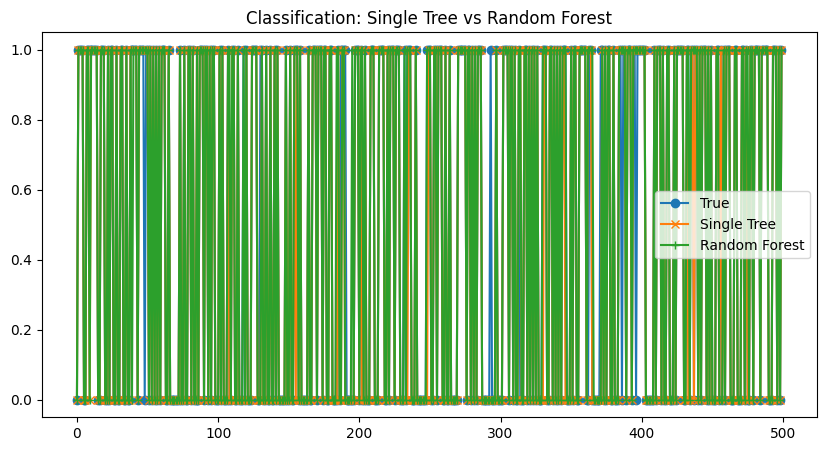

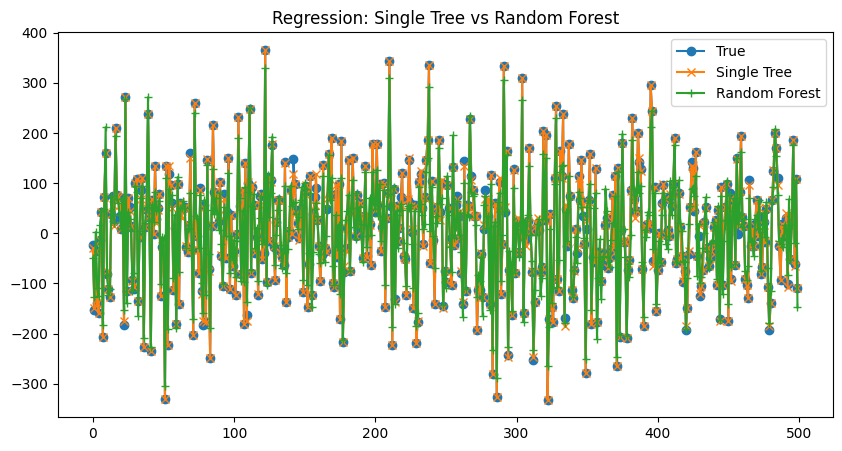

In [5]:
import numpy as np
from collections import Counter
import random

class DecisionTree:
    """
    A simple Decision Tree class for both classification and regression tasks.
    """

    def __init__(self, max_depth=None, min_samples_split=2, max_features=None):
        """
        Initialize the DecisionTree with optional parameters.

        :param max_depth: Maximum depth of the tree. If None, nodes are expanded until all leaves are pure.
        :param min_samples_split: Minimum number of samples required to split an internal node.
        :param max_features: The number of features to consider when looking for the best split. If None, consider all features.
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None
        self.is_classification = None

    def fit(self, X, y):
        """
        Fit the DecisionTree model to the training data.

        :param X: Training data features as a 2D numpy array.
        :param y: Training data labels/targets as a 1D numpy array.
        """
        # Determine if this is a classification or regression task
        self.is_classification = np.issubdtype(y.dtype, np.integer)

        # Set the number of features to consider for each split
        self.n_features = X.shape[1] if self.max_features is None else min(self.max_features, X.shape[1])

        # Build the decision tree
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        """
        Predict the labels/targets for the given data.

        :param X: Data to predict as a 2D numpy array.
        :return: Predicted labels/targets as a 1D numpy array.
        """
        # Check if the tree is built
        if self.tree is None:
            raise Exception("The model has not been trained yet. Call 'fit' before 'predict'.")

        # Predict for each sample
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.

        :param X: Data features as a 2D numpy array.
        :param y: Data labels/targets as a 1D numpy array.
        :param depth: Current depth of the tree.
        :return: The tree represented as nested dictionaries.
        """
        num_samples, num_features = X.shape
        # Check stopping conditions
        if num_samples >= self.min_samples_split and (self.max_depth is None or depth < self.max_depth):
            # Find the best feature and threshold to split the data
            best_feature, best_threshold = self._best_split(X, y)
            if best_feature is not None:
                left_indices = X[:, best_feature] < best_threshold
                right_indices = X[:, best_feature] >= best_threshold
                # Recursively build the left and right subtrees
                left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
                right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
                return {"feature": best_feature, "threshold": best_threshold, "left": left_subtree, "right": right_subtree}

        # Return a leaf node
        return self._leaf(y)

    def _best_split(self, X, y):
        """
        Find the best feature and threshold to split the data.

        :param X: Data features as a 2D numpy array.
        :param y: Data labels/targets as a 1D numpy array.
        :return: The best feature index and the best threshold for splitting.
        """
        best_gain = -float("inf")
        split_index, split_threshold = None, None
        # Consider a random subset of features
        for feature_index in random.sample(range(X.shape[1]), self.n_features):
            thresholds, gains = self._find_thresholds(X[:, feature_index], y)
            if gains:
                best_local_gain = max(gains)
                if best_local_gain > best_gain:
                    best_gain = best_local_gain
                    split_index = feature_index
                    split_threshold = thresholds[gains.index(best_local_gain)]
        return split_index, split_threshold

    def _find_thresholds(self, X_column, y):
        """
        Find the possible thresholds and their corresponding information gains.

        :param X_column: Data feature column as a 1D numpy array.
        :param y: Data labels/targets as a 1D numpy array.
        :return: List of possible thresholds and corresponding information gains.
        """
        thresholds, gains = [], []
        sorted_indices = np.argsort(X_column)
        X_column, y = X_column[sorted_indices], y[sorted_indices]
        for i in range(1, len(y)):
            if X_column[i] != X_column[i - 1]:
                threshold = (X_column[i] + X_column[i - 1]) / 2
                gain = self._information_gain(y, y[:i], y[i:])
                thresholds.append(threshold)
                gains.append(gain)
        return thresholds, gains

    def _information_gain(self, parent, left_child, right_child):
        """
        Calculate the information gain of a potential split.

        :param parent: Parent node labels/targets as a 1D numpy array.
        :param left_child: Left child node labels/targets as a 1D numpy array.
        :param right_child: Right child node labels/targets as a 1D numpy array.
        :return: The information gain of the split.
        """
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)

        # Use entropy for classification and variance reduction for regression
        if self.is_classification:
            return self._entropy(parent) - (weight_left * self._entropy(left_child) + weight_right * self._entropy(right_child))
        else:
            return self._variance_reduction(parent, left_child, right_child)

    def _entropy(self, y):
        """
        Calculate the entropy of a node.

        :param y: Node labels/targets as a 1D numpy array.
        :return: The entropy of the node.
        """
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _variance_reduction(self, parent, left_child, right_child):
        """
        Calculate the variance reduction of a potential split for regression.

        :param parent: Parent node labels/targets as a 1D numpy array.
        :param left_child: Left child node labels/targets as a 1D numpy array.
        :param right_child: Right child node labels/targets as a 1D numpy array.
        :return: The variance reduction of the split.
        """
        variance_parent = np.var(parent)
        variance_left = np.var(left_child)
        variance_right = np.var(right_child)
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        return variance_parent - (weight_left * variance_left + weight_right * variance_right)

    def _leaf(self, y):
        """
        Create a leaf node.

        :param y: Node labels/targets as a 1D numpy array.
        :return: The value to be predicted at the leaf node.
        """
        # For classification, return the most common class
        if self.is_classification:
            return Counter(y).most_common(1)[0][0]
        # For regression, return the mean value
        return np.mean(y)

    def _predict_one(self, x, tree):
        """
        Predict the target for a single data sample.

        :param x: Data sample as a 1D numpy array.
        :param tree: The decision tree as a nested dictionary.
        :return: The predicted label/target for the sample.
        """
        # Traverse the tree until a leaf node is reached
        if isinstance(tree, dict):
            if x[tree["feature"]] < tree["threshold"]:
                return self._predict_one(x, tree["left"])
            else:
                return self._predict_one(x, tree["right"])
        else:
            return tree


class RandomForest:
    """
    A Random Forest class that aggregates multiple decision trees for both classification and regression tasks.
    """

    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features=None):
        """
        Initialize the RandomForest with optional parameters.

        :param n_estimators: The number of trees in the forest.
        :param max_depth: Maximum depth of the trees. If None, nodes are expanded until all leaves are pure.
        :param min_samples_split: Minimum number of samples required to split an internal node.
        :param max_features: The number of features to consider when looking for the best split. If None, consider all features.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        """
        Fit the RandomForest model to the training data.

        :param X: Training data features as a 2D numpy array.
        :param y: Training data labels/targets as a 1D numpy array.
        """
        self.trees = []
        for _ in range(self.n_estimators):
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, max_features=self.max_features)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        """
        Predict the labels/targets for the given data.

        :param X: Data to predict as a 2D numpy array.
        :return: Aggregated predictions as a 1D numpy array.
        """
        # Check if the forest is built
        if not self.trees:
            raise Exception("The model has not been trained yet. Call 'fit' before 'predict'.")

        # Predict using each tree and aggregate predictions
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return self._aggregate_predictions(predictions)

    def _bootstrap_sample(self, X, y):
        """
        Create a bootstrap sample of the data.

        :param X: Data features as a 2D numpy array.
        :param y: Data labels/targets as a 1D numpy array.
        :return: A bootstrap sample of the data.
        """
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _aggregate_predictions(self, predictions):
        """
        Aggregate predictions from multiple trees.

        :param predictions: Predictions from all trees as a 2D numpy array.
        :return: The aggregated prediction as a 1D numpy array.
        """
        # For classification, use majority voting
        if np.issubdtype(predictions.dtype, np.integer):
            return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        # For regression, use the mean of predictions
        return np.mean(predictions, axis=0)

# === Usage Example and Comparison ===

from sklearn.datasets import make_classification, make_regression
import matplotlib.pyplot as plt

def plot_comparison(y_true, y_pred_tree, y_pred_forest, title, task_type="classification"):
    """
    Plot comparison between true labels/targets, single tree predictions, and random forest predictions.

    :param y_true: True labels/targets as a 1D numpy array.
    :param y_pred_tree: Predictions from a single tree as a 1D numpy array.
    :param y_pred_forest: Predictions from the random forest as a 1D numpy array.
    :param title: Title of the plot.
    :param task_type: Type of task ("classification" or "regression").
    """
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label="True", marker='o')
    plt.plot(y_pred_tree, label="Single Tree", marker='x')
    plt.plot(y_pred_forest, label="Random Forest", marker='+')
    plt.title(title)
    plt.legend()
    plt.show()

# Generate a classification dataset
X_class, y_class = make_classification(n_samples=500, n_features=5, n_informative=3, n_redundant=0, random_state=42)
# Generate a regression dataset
X_regress, y_regress = make_regression(n_samples=500, n_features=5, noise=0.1, random_state=42)

# Train a single decision tree for classification
tree_class = DecisionTree(max_depth=5)
tree_class.fit(X_class, y_class)
y_pred_tree_class = tree_class.predict(X_class)

# Train a random forest for classification
forest_class = RandomForest(n_estimators=10, max_depth=5)
forest_class.fit(X_class, y_class)
y_pred_forest_class = forest_class.predict(X_class)

# Train a single decision tree for regression
tree_regress = DecisionTree(max_depth=10)
tree_regress.fit(X_regress, y_regress)
y_pred_tree_regress = tree_regress.predict(X_regress)

# Train a random forest for regression
forest_regress = RandomForest(n_estimators=10, max_depth=5)
forest_regress.fit(X_regress, y_regress)
y_pred_forest_regress = forest_regress.predict(X_regress)

# Plot comparisons
plot_comparison(y_class, y_pred_tree_class, y_pred_forest_class, "Classification: Single Tree vs Random Forest", task_type="classification")
plot_comparison(y_regress, y_pred_tree_regress, y_pred_forest_regress, "Regression: Single Tree vs Random Forest", task_type="regression")


In [6]:
from sklearn.metrics import mean_squared_error, accuracy_score

def print_comparison_metrics(y_true, y_pred_tree, y_pred_forest, task_type="classification"):
    """
    Print the comparison metrics for single tree and random forest.

    :param y_true: True labels/targets as a 1D numpy array.
    :param y_pred_tree: Predictions from a single tree as a 1D numpy array.
    :param y_pred_forest: Predictions from the random forest as a 1D numpy array.
    :param task_type: Type of task ("classification" or "regression").
    """
    if task_type == "classification":
        tree_accuracy = accuracy_score(y_true, y_pred_tree)
        forest_accuracy = accuracy_score(y_true, y_pred_forest)
        print(f"Classification Accuracy - Single Tree: {tree_accuracy:.4f}")
        print(f"Classification Accuracy - Random Forest: {forest_accuracy:.4f}")
    elif task_type == "regression":
        tree_mse = mean_squared_error(y_true, y_pred_tree)
        forest_mse = mean_squared_error(y_true, y_pred_forest)
        print(f"Regression MSE - Single Tree: {tree_mse:.4f}")
        print(f"Regression MSE - Random Forest: {forest_mse:.4f}")

# Print classification accuracy comparison
print_comparison_metrics(y_class, y_pred_tree_class, y_pred_forest_class, task_type="classification")

# Print regression MSE comparison
print_comparison_metrics(y_regress, y_pred_tree_regress, y_pred_forest_regress, task_type="regression")


Classification Accuracy - Single Tree: 0.9600
Classification Accuracy - Random Forest: 0.9580
Regression MSE - Single Tree: 33.0570
Regression MSE - Random Forest: 988.3346
